In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import PHELPH

import sys
sys.path.append("../utils/")
import fermi_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0 #0.02
system.tau_photon = 200
system.E_photon = 0.0175
system.linewidth = 0.005

system.setup_laser()

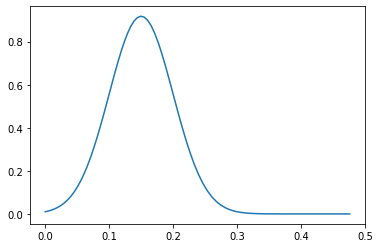

In [3]:
inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.12, I_0=1e-6)

plt.plot(system.E_el_vec,inits[:system.n_kmax])
plt.show()

In [4]:
trajectory = system.get_full_trajectory(inits, tmax=tmax, n_tmax=n_tmax)

el_trajectory = trajectory[:,:system.n_kmax]

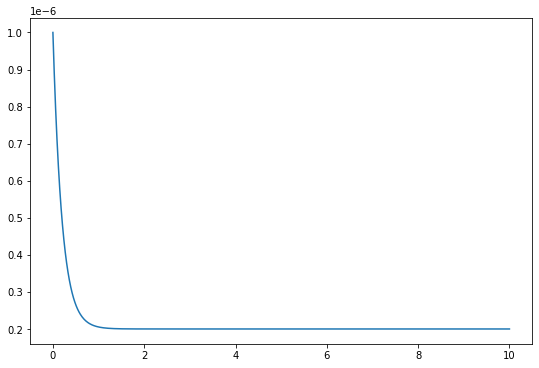

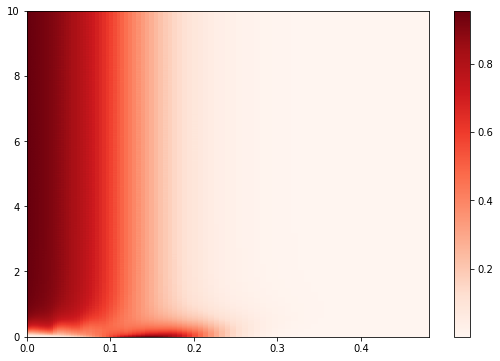

In [21]:
plt.plot(t_vec/1000,trajectory[:,-1])
plt.show()

plt.pcolormesh(system.E_el_vec, t_vec/1000, el_trajectory,cmap='Reds')
plt.colorbar()
plt.show()


In [6]:
fermi_fitter = fermi_fit.fermi_fit(system.DOS_vec,system.E_el_vec,system.kB)

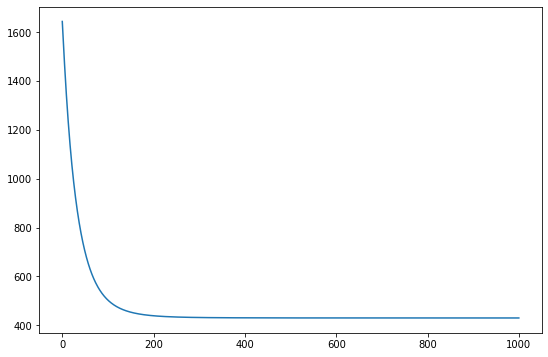

In [22]:
Te_vec = []
mus = []
Steps = []

ind_start = 0

for k in range(el_trajectory[ind_start:].shape[0]):
    mu,Temp,steps = fermi_fitter.fit_mu_T(el_trajectory[ind_start:][k], 0.1, 300, False)
    mus.append(mu)
    Te_vec.append(Temp)
    Steps.append(steps)

Te_vec = np.asarray(Te_vec)
    
plt.plot(Te_vec)
plt.show()

# plt.plot(mus)
# plt.show()

# plt.plot(Steps)
# plt.show()

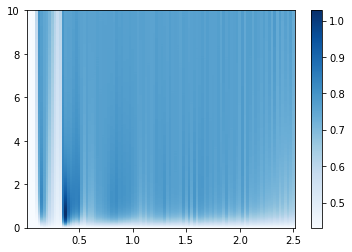

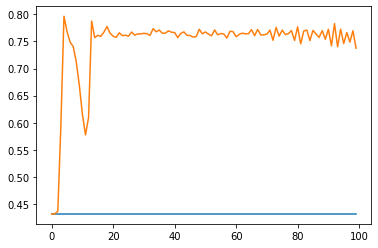

In [8]:
alpha = 0

ph_trajectory = trajectory[:,(alpha+1)*system.n_kmax:(alpha+2)*system.n_kmax]

plt.pcolormesh(system.k_vec, t_vec/1000, ph_trajectory,cmap='Blues')
plt.colorbar()
plt.show()

plt.plot(ph_trajectory[0])
plt.plot(ph_trajectory[-1])
plt.show()

In [9]:
from scipy.optimize import minimize_scalar

In [10]:
def bose(E,T):
    return 1./(np.exp(E/(system.kB*T))-1.)

def fit_bose(state,alpha=0):
    
    ens_vec = system.phonon_dispersion(system.k_vec,0,alpha)
    
    def get_en(stt):
        return np.sum(stt*system.DOS_vec*ens_vec)
    
    dens = np.sum(state*system.DOS_vec)
    
    en = get_en(state) #np.sum(state*system.DOS_vec*ens_vec)
    
#     print('dens: ', dens, 'en: ', en)
    
    def loss(T):
#         return np.square(dens - np.sum(bose(ens_vec,T)*system.DOS_vec))
        return np.square(en - get_en(bose(ens_vec,T))) #np.sum(bose(ens_vec,T)*system.DOS_vec*ens_vec))
    
    res = minimize_scalar(loss, bounds=(1, 1000), method='bounded') 

#     print(res.x)
    
#     print(np.sum(bose(ens_vec,res.x)*system.DOS_vec), get_en(bose(ens_vec,res.x)))
    
    return res.x
    
    
fit_bose(ph_trajectory[-1])
    
    

428.7819643353194

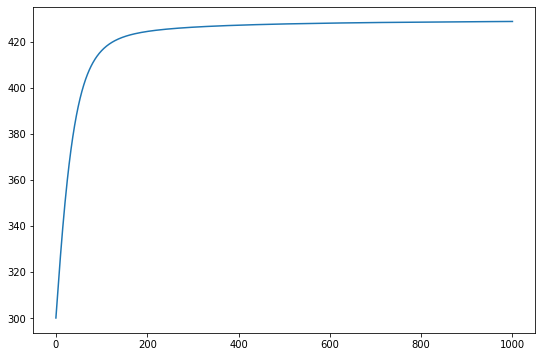

In [23]:
Tp_vec = []

for state in ph_trajectory:
    Tp_vec.append(fit_bose(state,0))
    
Tp_vec = np.asarray(Tp_vec)
    
plt.plot(Tp_vec)
plt.show()

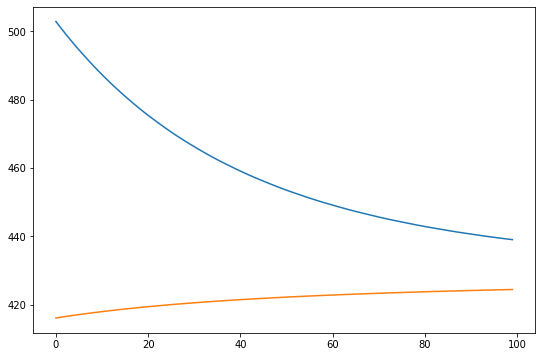

In [30]:
ind_lower = 100
ind_upper = 200

Te = np.asarray(Te_vec[ind_lower:ind_upper])
Tp = np.asarray(Tp_vec[ind_lower:ind_upper])

plt.plot(Te)
plt.plot(Tp)
plt.show()



nstp = 1


dTp = (Tp_vec[ind_lower:ind_upper]-Tp_vec[ind_lower-nstp:ind_upper-nstp])/(10.0*nstp)
# print(dTp.shape)

dTe = (Te_vec[ind_lower:ind_upper]-Te_vec[ind_lower-nstp:ind_upper-nstp])/(10.0*nstp)
# print(dTe.shape)


# plt.plot(dTp)
# plt.show()

# plt.plot(dTe)
# plt.show()

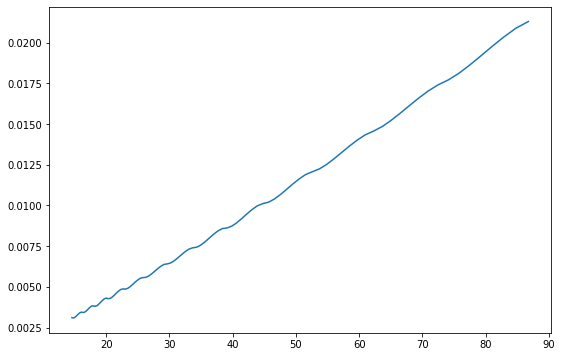

4317.133048386933


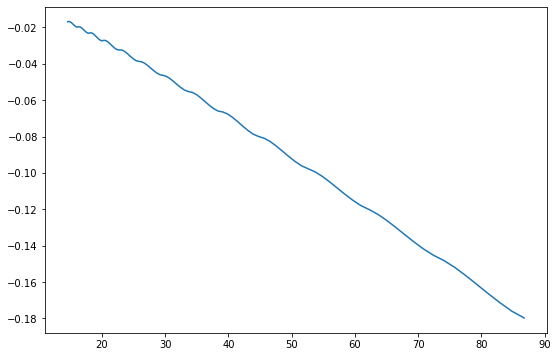

539.9801930532757


In [31]:
plt.plot(Te-Tp,dTp)
plt.show()

gamma_p = dTp@(Te-Tp)/((Te-Tp)@(Te-Tp))
print(1/gamma_p)


plt.plot(Te-Tp,dTe)
# plt.plot(dTp)
plt.show()

gamma_e = dTe@(Tp-Te)/((Tp-Te)@(Tp-Te))
print(1/gamma_e)


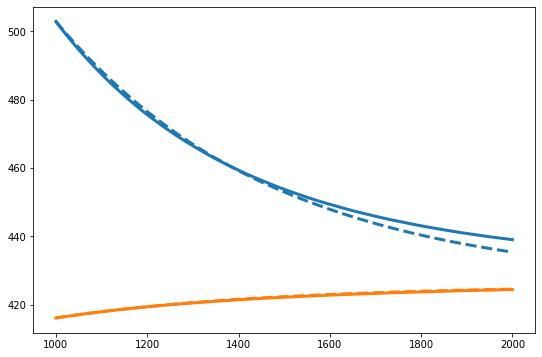

In [32]:
tau_te = 1/gamma_e
tau_tp = 1/gamma_p

def Tderivs(t,y):
    te = y[0]
    tp = y[1]
    
    dte = (tp-te)/tau_te
    dtp = (te-tp)/tau_tp
    
    return [dte,dtp]

from scipy.integrate import solve_ivp as scpy_solve_ivp


tvec = np.linspace(ind_lower*10.,ind_upper*10,ind_upper-ind_lower)

test_inits=[Te[0],Tp[0]]

sol = scpy_solve_ivp(Tderivs, [tvec[0],tvec[-1]], test_inits, t_eval=tvec)


plt.plot(tvec,Te,c='C0',lw=3)
plt.plot(tvec,Tp,c='C1',lw=3)

plt.plot(tvec,sol.y[0],'--',c='C0',lw=3)
plt.plot(tvec,sol.y[1],'--',c='C1',lw=3)

plt.show()

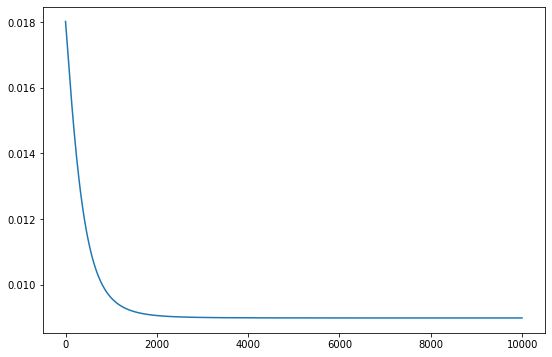

[5.51263086e-03 4.47967482e+02 8.98813019e-03]
[8.62295607e-03 3.28945120e-03 2.93916403e-05]
tau_rel: 447.9674819329651


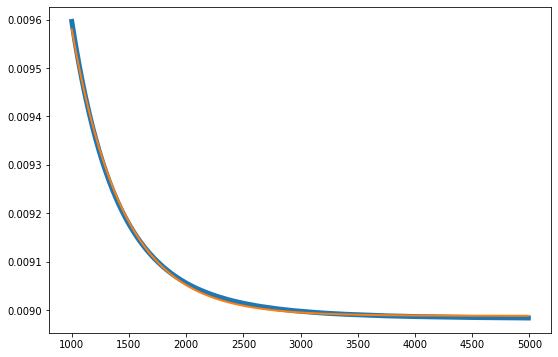

In [29]:
E = np.zeros((el_trajectory.shape[0]))
for k in range(E.size):
    E[k] =  np.sum(el_trajectory[k]*system.DOS_vec*system.E_el_vec)
    
plt.plot(t_vec,E)
plt.show()


# ind0 = 200
# indd = 200

# t_fit = t_vec[ind0:ind0+indd]
# E_fit = E[ind0:ind0+indd]

t_fit = t_vec[ind_lower:ind_upper]
E_fit = E[ind_lower:ind_upper]

# plt.plot(t_fit,E_fit)
# plt.show()

def fit_exp(t,A,tau,offset):
    return A*np.exp(-t/tau) + offset


from scipy.optimize import curve_fit

popt, pcov = curve_fit(fit_exp, t_fit, E_fit, [0.0001,700,0.009])
perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr/popt)

print('tau_rel:',popt[1])


plt.plot(t_fit,E_fit, lw=5)
plt.plot(t_fit, fit_exp(t_fit,*popt), lw=2)
plt.show()

In [18]:
ttrt_inits = np.concatenate([el_trajectory[0,:system.n_kmax],[system.T_cryo],[trajectory[0,-1]]])
ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500, tau_Tp=4000)

In [36]:
Te_vec_approx = []
mus = []
Steps = []

ind_start = 0

for k in range(ttrt_approx[:,:-2].shape[0]):
    mu,Temp,steps = fermi_fitter.fit_mu_T(ttrt_approx[:,:-2][k], 0.1, 300, False)
    mus.append(mu)
    Te_vec_approx.append(Temp)
    Steps.append(steps)

Te_vec_approx = np.asarray(Te_vec_approx)
    


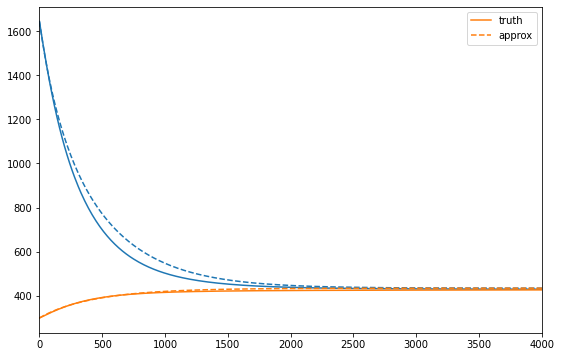

In [43]:
plt.plot(t_vec,Te_vec, c='C0')
plt.plot(t_vec,Te_vec_approx, '--', c='C0')

plt.plot(t_vec,Tp_vec,label='truth', c='C1')
plt.plot(t_vec,ttrt_approx[:,-2],'--', c='C1',label='approx',)
plt.legend()

plt.xlim(0,4000)
# plt.ylim(300,00)

plt.show()

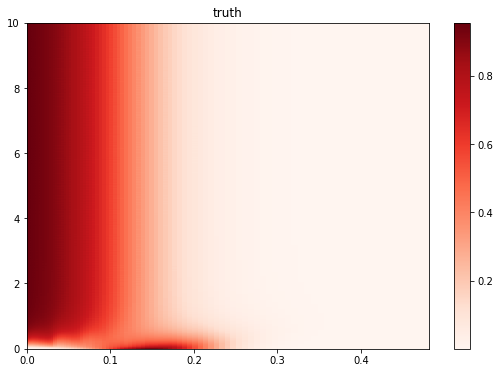

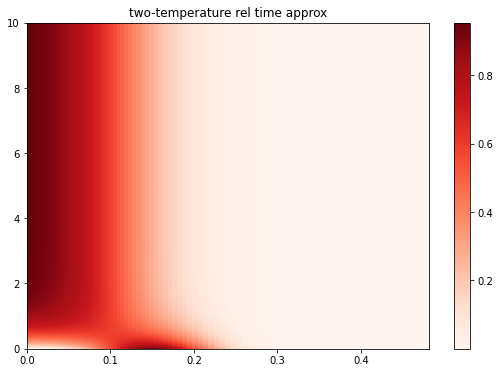

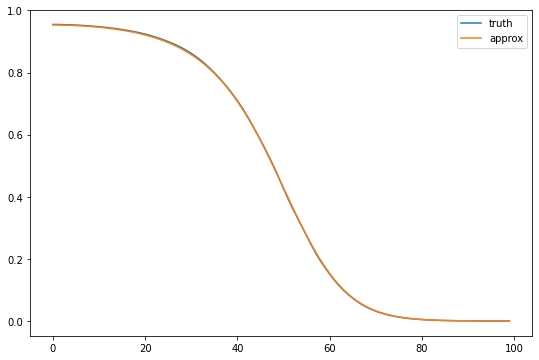

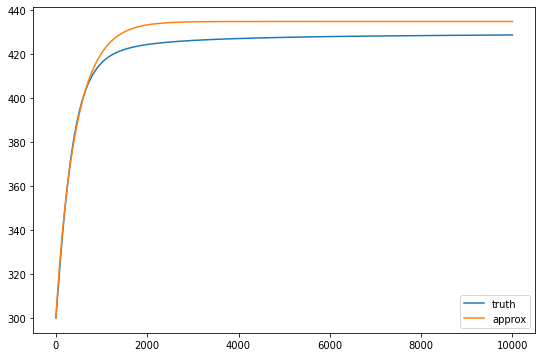

In [33]:
plt.pcolormesh(system.E_el_vec, t_vec/1000, el_trajectory,cmap='Reds')
plt.colorbar()
plt.title('truth')
plt.show()

plt.pcolormesh(system.E_el_vec, t_vec/1000, ttrt_approx[:,:-2],cmap='Reds')
plt.colorbar()
plt.title('two-temperature rel time approx')
plt.show()


plt.plot(el_trajectory[-1],label='truth')
plt.plot(ttrt_approx[-1,:-2],label='approx')
plt.legend()
plt.show()


plt.plot(t_vec,Tp_vec,label='truth')
plt.plot(t_vec,ttrt_approx[:,-2],label='approx')
plt.legend()
plt.show()
